# Credit Card Fraud Detection

In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('./Datasets/train.csv')

In [3]:
import random

test_index_1 = random.sample(list(train[train.Class==1].index), int(15*train[train.Class==1].shape[0]/100))
test_index_0 = random.sample(list(train[train.Class==0].index), int(15*train[train.Class==0].shape[0]/100))

test = train.iloc[test_index_1+test_index_0]
train.drop(test_index_1+test_index_0, inplace=True)
train.reset_index(drop=True, inplace=True)

In [4]:
train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


## EDA & Feature Engineering

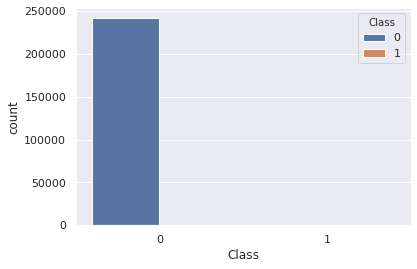

In [5]:
sns.countplot(x='Class', data=train, hue="Class")
plt.show()

### Highly imbalance data, Fraud data points only 0.0017%

In [6]:
print(f"Fraud instaces: {train[train['Class']==1].shape[0]}")
print(f"Non Fraud instaces: {train[train['Class']==0].shape[0]}")
print(f"Fraud percentage: {train[train['Class']==1].shape[0]/train.shape[0]}")
print(f"Non Fraud percentage: {train[train['Class']==0].shape[0]/train.shape[0]}")

Fraud instaces: 419
Non Fraud instaces: 241668
Fraud percentage: 0.001730782735132411
Non Fraud percentage: 0.9982692172648676


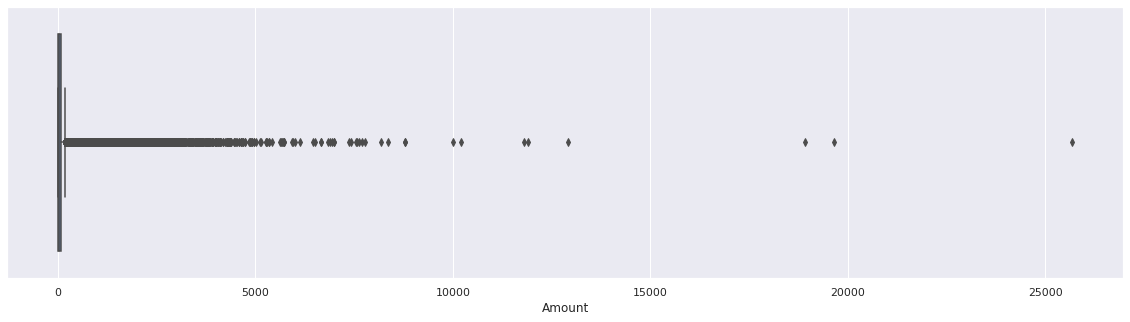

In [7]:
plt.figure(figsize=(20, 5))
sns.boxplot(x=train.Amount)

Outliers Removal, for amount greater  than 10000

In [8]:
train = train[train['Amount']  <= 10000]
train.reset_index(drop=True, inplace=True)

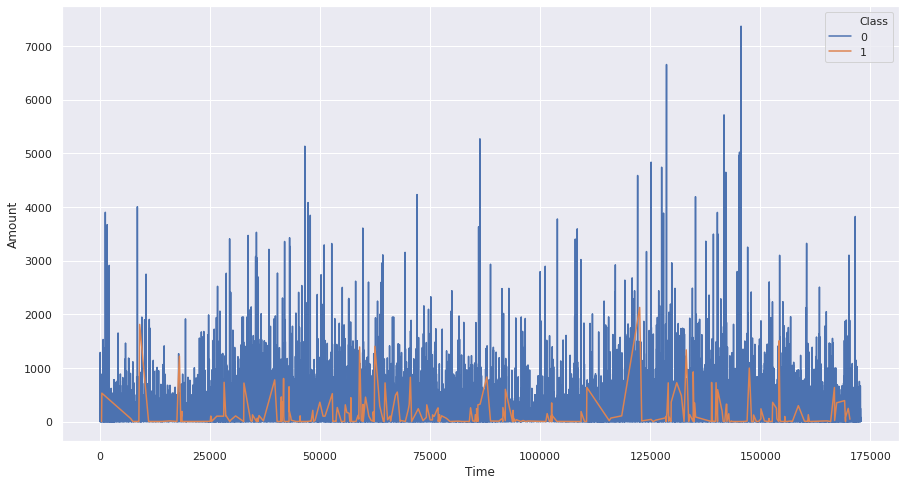

In [9]:
plt.figure(figsize=(15, 8))
sns.lineplot(x="Time", y="Amount", hue="Class", data=train, ci=None)
plt.show()

Unfortunately **Time** and **Amount** can't be distinguishing features for Fraud as can be seen from the above distribution

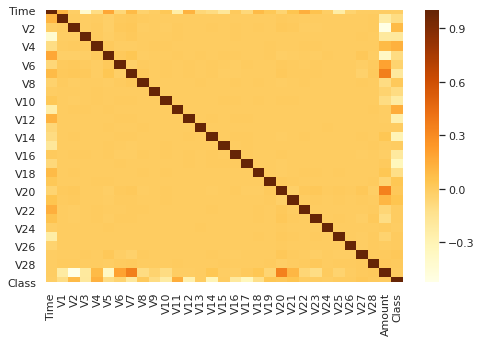

In [10]:
plt.figure(figsize=(8, 5))
sns.heatmap(data = train.corr(), cmap = "YlOrBr")

As expected there are hardly any correlation between any features which is expected since the dataset contained features which were PCAs

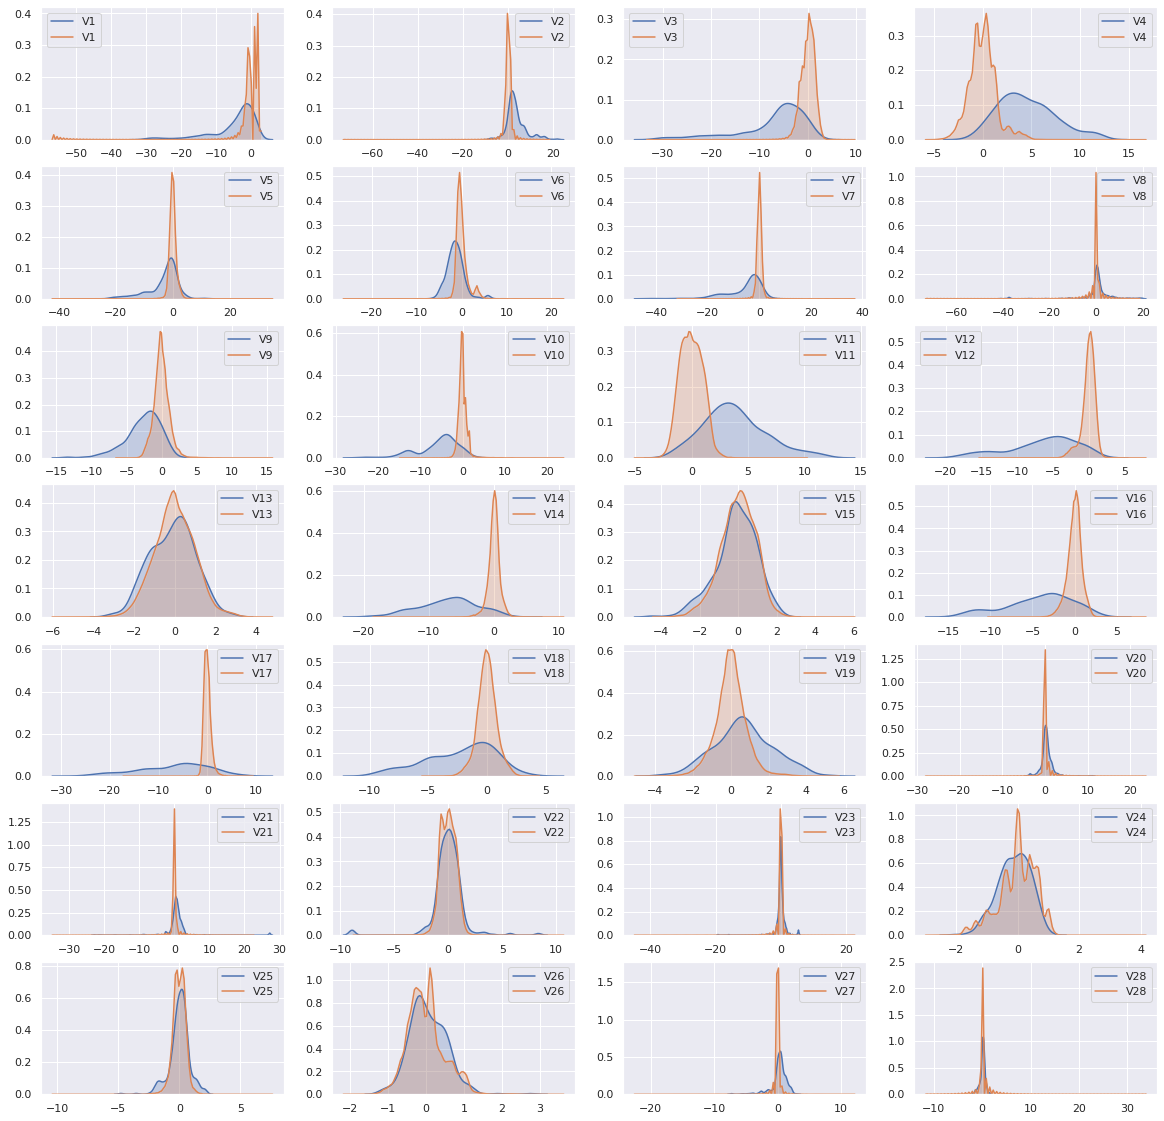

In [11]:
fig, ax = plt.subplots(7, 4, figsize=(20, 20))
for i in range(0, 28):
    sns.kdeplot(train[train['Class']==1][f'V{i+1}'], shade=True, ax=ax[int(i/4)][i%4])
    sns.kdeplot(train[train['Class']==0][f'V{i+1}'], shade=True, ax=ax[int(i/4)][i%4])
fig.show()

From the above it can be seen that the distribution of some of the features is similar for Fraud and non Fraud has, they will not be of much use and it is better to remove them.

In [12]:
train.drop(['V13', 'V15', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'], axis=1, inplace=True)
test.drop(['V13', 'V15', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'], axis=1, inplace=True)

### Scale data

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train.drop('Class', axis=1))

test_y = test.Class
test = test.drop('Class', axis=1)
test = scaler.transform(test)

class_0_train_1000 = train[train.Class==0].sample(1000)

### To handle imbalance data, we will use **SMOTE** for over sampling  and random sampling for undersampling

In [14]:
from imblearn.over_sampling import SMOTE

#Sample
sampled_data = class_0_train_1000
sampled_data = pd.concat([sampled_data, train[train.Class==1]], ignore_index=True)
sampled_data = sampled_data.sample(frac=1).reset_index(drop=True)

#Over sample
oversampled_data, oversampled_y = SMOTE(k_neighbors=7).fit_resample(sampled_data.drop('Class', axis=1), sampled_data.Class)
oversampled_data['Class'] =  oversampled_y
oversampled_data_std = scaler.transform(oversampled_data.drop('Class', axis=1))
oversampled_data_std = pd.DataFrame(oversampled_data_std)
oversampled_data_std['Class'] = oversampled_data.Class
oversampled_data_std.columns = oversampled_data.columns

#Under sample
undersampled_data = class_0_train_1000
undersampled_data = pd.concat([undersampled_data, train[train.Class==1]], ignore_index=True)
undersampled_data = undersampled_data.sample(frac=1).reset_index(drop=True)
undersampled_data_std = scaler.transform(undersampled_data.drop('Class', axis=1))
undersampled_data_std = pd.DataFrame(undersampled_data_std)
undersampled_data_std['Class'] = undersampled_data.Class
undersampled_data_std.columns = undersampled_data.columns

Using TensorFlow backend.


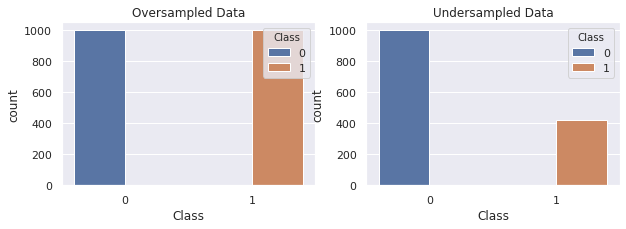

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.countplot(x='Class', data=oversampled_data, hue="Class", ax=ax[0])
ax[0].title.set_text(f'Oversampled Data')
sns.countplot(x='Class', data=undersampled_data, hue="Class", ax=ax[1])
ax[1].title.set_text(f'Undersampled Data')

Now the distribution of data between the two classes is reasonable and can be applied to different algorithms

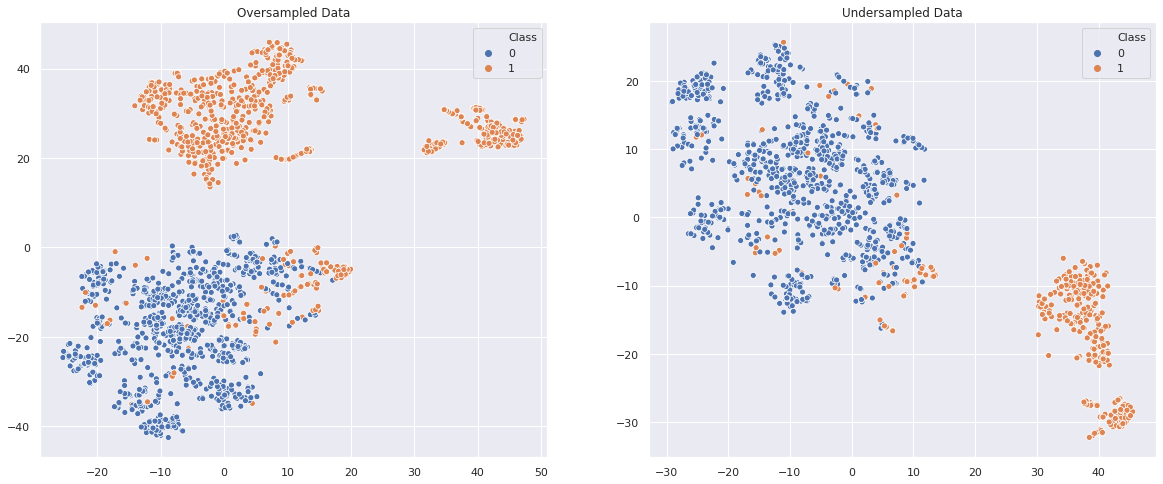

In [16]:
from sklearn.manifold import TSNE

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
tsne = TSNE(n_components=2, random_state=42, perplexity=75).fit_transform(oversampled_data_std)
sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=oversampled_data_std.Class, ax=ax[0])
ax[0].title.set_text(f'Oversampled Data')

tsne = TSNE(n_components=2, random_state=42, perplexity=75).fit_transform(undersampled_data_std)
sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=undersampled_data_std.Class, ax=ax[1])
ax[1].title.set_text(f'Undersampled Data')

**TSNE** shows different multiple clusters for Fraud and Non Fraud which means we expect classifications methods like SVM, Logistic Regression Classifier, Nearest Neighbors to work reasonably well on the dataset

### KNeighborsClassifier

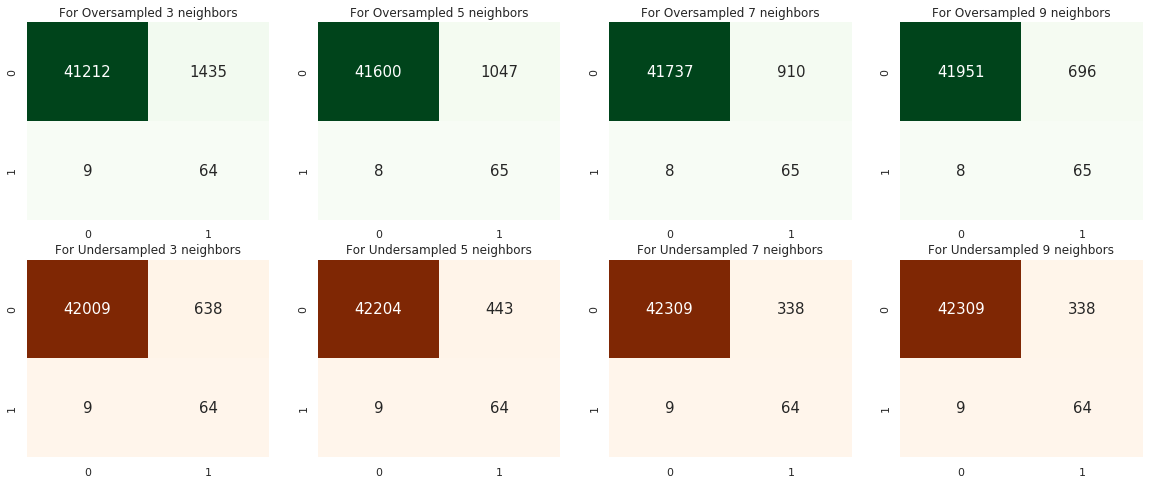

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(2, 4, figsize=(20, 8))
i = 0
for n in range(3, 10, 2):
    knn = KNeighborsClassifier(n).fit(oversampled_data_std.drop(['Class'], axis=1).values, oversampled_data_std.Class.values)
    y_pred = knn.predict(test)    
    sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[0][i], cmap="Greens", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
    bottom, top = ax[0][i].get_ylim()
    ax[0][i].set_ylim(bottom + 0.5, top - 0.5)
    ax[0][i].title.set_text(f'For Oversampled {n} neighbors')
    i+=1
    
i = 0
for n in range(3, 10, 2):
    knn = KNeighborsClassifier(n).fit(undersampled_data_std.drop(['Class'], axis=1).values, undersampled_data_std.Class.values)
    y_pred = knn.predict(test)    
    sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[1][i], cmap="Oranges", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
    bottom, top = ax[1][i].get_ylim()
    ax[1][i].set_ylim(bottom + 0.5, top - 0.5)
    ax[1][i].title.set_text(f'For Undersampled {n} neighbors')
    i+=1

### Logistic Regression w/ L1 and L2 Regularization

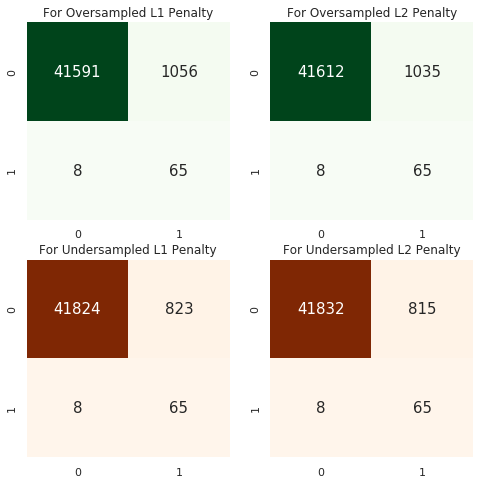

In [18]:
from sklearn.linear_model import LogisticRegression

fig, ax = plt.subplots(2, 2, figsize=(8, 8))

lg = LogisticRegression(penalty='l1', solver='liblinear')\
    .fit(oversampled_data_std.drop(['Class'], axis=1).values, oversampled_data_std.Class.values)
y_pred = lg.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[0][0], cmap="Greens", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[0][0].get_ylim()
ax[0][0].set_ylim(bottom + 0.5, top - 0.5)
ax[0][0].title.set_text(f'For Oversampled L1 Penalty')

lg = LogisticRegression(penalty='l2', solver='liblinear')\
    .fit(oversampled_data_std.drop(['Class'], axis=1).values, oversampled_data_std.Class.values)
y_pred = lg.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[0][1], cmap="Greens", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[0][1].get_ylim()
ax[0][1].set_ylim(bottom + 0.5, top - 0.5)
ax[0][1].title.set_text(f'For Oversampled L2 Penalty')
                                                                
lg = LogisticRegression(penalty='l1', solver='liblinear')\
    .fit(undersampled_data_std.drop(['Class'], axis=1).values, undersampled_data_std.Class.values)
y_pred = lg.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[1][0], cmap="Oranges", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[1][0].get_ylim()
ax[1][0].set_ylim(bottom + 0.5, top - 0.5)
ax[1][0].title.set_text(f'For Undersampled L1 Penalty')

lg = LogisticRegression(penalty='l2', solver='liblinear')\
    .fit(undersampled_data_std.drop(['Class'], axis=1).values, undersampled_data_std.Class.values)
y_pred = lg.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[1][1], cmap="Oranges", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[1][1].get_ylim()
ax[1][1].set_ylim(bottom + 0.5, top - 0.5)
ax[1][1].title.set_text(f'For Undersampled L2 Penalty')

### SVM w/ Linear and RBF Kernels

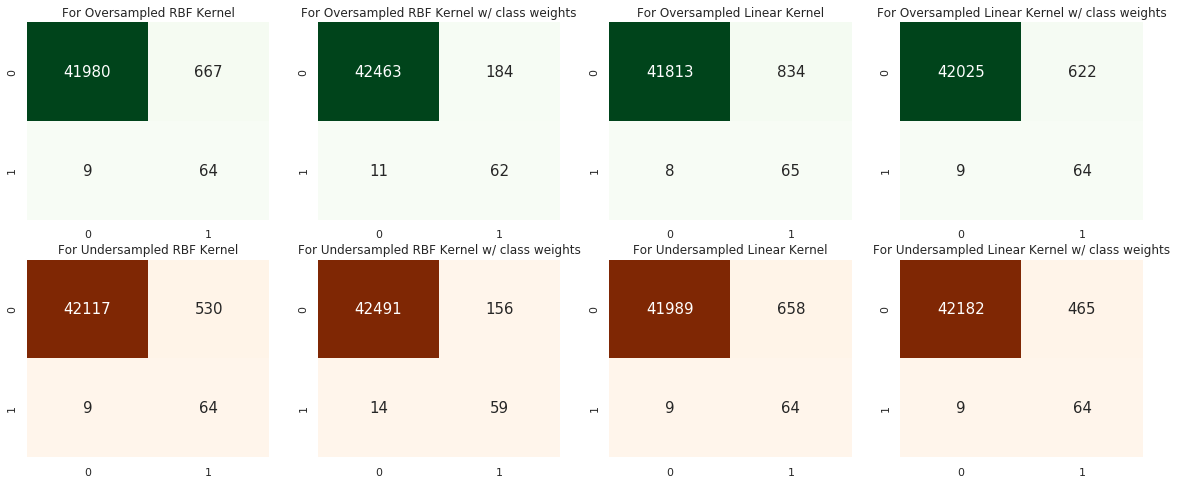

In [19]:
from sklearn.svm import SVC

fig, ax = plt.subplots(2, 4, figsize=(20, 8))


svm = SVC(kernel='rbf')\
    .fit(oversampled_data_std.drop(['Class'], axis=1).values, oversampled_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[0][0], cmap="Greens", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[0][0].get_ylim()
ax[0][0].set_ylim(bottom + 0.5, top - 0.5)
ax[0][0].title.set_text(f'For Oversampled RBF Kernel')

svm = SVC(kernel='rbf', class_weight={0:0.70, 1:0.30})\
    .fit(oversampled_data_std.drop(['Class'], axis=1).values, oversampled_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[0][1], cmap="Greens", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[0][1].get_ylim()
ax[0][1].set_ylim(bottom + 0.5, top - 0.5)
ax[0][1].title.set_text(f'For Oversampled RBF Kernel w/ class weights')

svm = SVC(kernel='linear')\
    .fit(oversampled_data_std.drop(['Class'], axis=1).values, oversampled_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[0][2], cmap="Greens", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[0][2].get_ylim()
ax[0][2].set_ylim(bottom + 0.5, top - 0.5)
ax[0][2].title.set_text(f'For Oversampled Linear Kernel')

svm = SVC(kernel='linear', class_weight={0:0.60, 1:0.40})\
    .fit(oversampled_data_std.drop(['Class'], axis=1).values, oversampled_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[0][3], cmap="Greens", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[0][3].get_ylim()
ax[0][3].set_ylim(bottom + 0.5, top - 0.5)
ax[0][3].title.set_text(f'For Oversampled Linear Kernel w/ class weights')

svm = SVC(kernel='rbf')\
    .fit(undersampled_data_std.drop(['Class'], axis=1).values, undersampled_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[1][0], cmap="Oranges", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[1][0].get_ylim()
ax[1][0].set_ylim(bottom + 0.5, top - 0.5)
ax[1][0].title.set_text(f'For Undersampled RBF Kernel')

svm = SVC(kernel='rbf', class_weight={0:0.70, 1:0.30})\
    .fit(undersampled_data_std.drop(['Class'], axis=1).values, undersampled_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[1][1], cmap="Oranges", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[1][1].get_ylim()
ax[1][1].set_ylim(bottom + 0.5, top - 0.5)
ax[1][1].title.set_text(f'For Undersampled RBF Kernel w/ class weights')

svm = SVC(kernel='linear')\
    .fit(undersampled_data_std.drop(['Class'], axis=1).values, undersampled_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[1][2], cmap="Oranges", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[1][2].get_ylim()
ax[1][2].set_ylim(bottom + 0.5, top - 0.5)
ax[1][2].title.set_text(f'For Undersampled Linear Kernel')

svm = SVC(kernel='linear', class_weight={0:0.60, 1:0.40})\
    .fit(undersampled_data_std.drop(['Class'], axis=1).values, undersampled_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[1][3], cmap="Oranges", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[1][3].get_ylim()
ax[1][3].set_ylim(bottom + 0.5, top - 0.5)
ax[1][3].title.set_text(f'For Undersampled Linear Kernel w/ class weights')

## Neural Networks on Undersampled and Oversampled Data

In [20]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import Adam

val_index_1 = random.sample(list(undersampled_data_std[undersampled_data_std.Class==1].index), 
                                int(15*undersampled_data_std[undersampled_data_std.Class==1].shape[0]/100))
val_index_0 = random.sample(list(undersampled_data_std[undersampled_data_std.Class==0].index), 
                                int(15*undersampled_data_std[undersampled_data_std.Class==0].shape[0]/100))

val = undersampled_data_std.iloc[val_index_0+val_index_1]
val_X = val.drop('Class', axis=1)
val_y = val.Class
data_X = undersampled_data_std.drop(val_index_1+val_index_0)

undersampled_data_X = data_X.drop('Class', axis=1)
undersampled_data_y = data_X.Class
n_inputs = undersampled_data_X.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
undersample_model.fit(undersampled_data_X.values, undersampled_data_y.values, 
                      validation_data=(val_X.values, val_y.values), batch_size=16, 
                      epochs=10, shuffle=True, verbose=2)

Train on 1207 samples, validate on 212 samples
Epoch 1/10
 - 1s - loss: 0.3649 - accuracy: 0.8998 - val_loss: 0.2153 - val_accuracy: 0.9481
Epoch 2/10
 - 0s - loss: 0.1792 - accuracy: 0.9577 - val_loss: 0.1656 - val_accuracy: 0.9481
Epoch 3/10
 - 0s - loss: 0.1370 - accuracy: 0.9602 - val_loss: 0.1457 - val_accuracy: 0.9481
Epoch 4/10
 - 0s - loss: 0.1190 - accuracy: 0.9652 - val_loss: 0.1362 - val_accuracy: 0.9528
Epoch 5/10
 - 0s - loss: 0.1082 - accuracy: 0.9669 - val_loss: 0.1291 - val_accuracy: 0.9528
Epoch 6/10
 - 0s - loss: 0.1021 - accuracy: 0.9677 - val_loss: 0.1233 - val_accuracy: 0.9528
Epoch 7/10
 - 0s - loss: 0.0962 - accuracy: 0.9702 - val_loss: 0.1235 - val_accuracy: 0.9434
Epoch 8/10
 - 0s - loss: 0.0918 - accuracy: 0.9718 - val_loss: 0.1233 - val_accuracy: 0.9434
Epoch 9/10
 - 0s - loss: 0.0874 - accuracy: 0.9727 - val_loss: 0.1177 - val_accuracy: 0.9434
Epoch 10/10
 - 0s - loss: 0.0837 - accuracy: 0.9735 - val_loss: 0.1175 - val_accuracy: 0.9481


In [21]:
val_index_1 = random.sample(list(oversampled_data_std[oversampled_data_std.Class==1].index), int(15*oversampled_data_std[oversampled_data_std.Class==1].shape[0]/100))
val_index_0 = random.sample(list(oversampled_data_std[oversampled_data_std.Class==0].index), int(15*oversampled_data_std[oversampled_data_std.Class==0].shape[0]/100))

val = oversampled_data_std.iloc[val_index_0+val_index_1]
val_X = val.drop('Class', axis=1)
val_y = val.Class
data_X = oversampled_data_std.drop(val_index_1+val_index_0)

oversampled_data_X = data_X.drop('Class', axis=1)
oversampled_data_y = data_X.Class
n_inputs = oversampled_data_X.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
oversample_model.fit(oversampled_data_X.values, oversampled_data_y.values, 
                      validation_data=(val_X.values, val_y.values), batch_size=16, 
                      epochs=10, shuffle=True, verbose=2)

Train on 1700 samples, validate on 300 samples
Epoch 1/10
 - 1s - loss: 0.2905 - accuracy: 0.8912 - val_loss: 0.1546 - val_accuracy: 0.9667
Epoch 2/10
 - 0s - loss: 0.1512 - accuracy: 0.9547 - val_loss: 0.1053 - val_accuracy: 0.9700
Epoch 3/10
 - 1s - loss: 0.1156 - accuracy: 0.9624 - val_loss: 0.0936 - val_accuracy: 0.9667
Epoch 4/10
 - 0s - loss: 0.1006 - accuracy: 0.9647 - val_loss: 0.0920 - val_accuracy: 0.9667
Epoch 5/10
 - 0s - loss: 0.0923 - accuracy: 0.9659 - val_loss: 0.0929 - val_accuracy: 0.9667
Epoch 6/10
 - 0s - loss: 0.0860 - accuracy: 0.9700 - val_loss: 0.0915 - val_accuracy: 0.9667
Epoch 7/10
 - 0s - loss: 0.0815 - accuracy: 0.9682 - val_loss: 0.0944 - val_accuracy: 0.9667
Epoch 8/10
 - 0s - loss: 0.0762 - accuracy: 0.9712 - val_loss: 0.0950 - val_accuracy: 0.9667
Epoch 9/10
 - 0s - loss: 0.0717 - accuracy: 0.9759 - val_loss: 0.1010 - val_accuracy: 0.9667
Epoch 10/10
 - 0s - loss: 0.0682 - accuracy: 0.9765 - val_loss: 0.0975 - val_accuracy: 0.9667


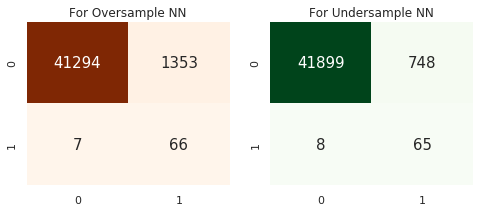

In [22]:
oversample_predictions = oversample_model.predict(test, batch_size=200, verbose=0)
oversample_pred =  pd.DataFrame(oversample_predictions[:,0] < oversample_predictions[:,1])
oversample_pred.columns = ['Class']
oversample_pred.Class.apply(lambda x : 1 if x else 0)

undersample_predictions = undersample_model.predict(test, batch_size=200, verbose=0)
undersample_pred =  pd.DataFrame(undersample_predictions[:,0] < undersample_predictions[:,1])
undersample_pred.columns = ['Class']
undersample_pred.Class.apply(lambda x : 1 if x else 0)

fig, ax = plt.subplots(1, 2, figsize=(8,3))

sns.heatmap(confusion_matrix(test_y, oversample_pred), 
            annot=True, cmap="Oranges", 
            cbar = False, fmt='.0f', annot_kws={"fontsize":15}, ax=ax[0])
bottom, top = ax[0].get_ylim()
ax[0].set_ylim(bottom + 0.5, top - 0.5)
ax[0].title.set_text(f'For Oversample NN')

sns.heatmap(confusion_matrix(test_y, undersample_pred), 
            annot=True, cmap="Greens", 
            cbar = False, fmt='.0f', annot_kws={"fontsize":15}, ax=ax[1])
bottom, top = ax[1].get_ylim()
ax[1].set_ylim(bottom + 0.5, top - 0.5)
ax[1].title.set_text(f'For Undersample NN')

## Neural Network on the entire dataset

In [23]:
train_std = scaler.transform(train.drop('Class', axis=1))
train_std = pd.DataFrame(train_std)
train_std['Class'] = train.Class
train_std.columns = train.columns

val_index_1 = random.sample(list(train_std[train_std.Class==1].index), int(15*train_std[train_std.Class==1].shape[0]/100))
val_index_0 = random.sample(list(train_std[train_std.Class==0].index), int(15*train_std[train_std.Class==0].shape[0]/100))

val = train_std.iloc[val_index_0+val_index_1]
val_X = val.drop('Class', axis=1)
val_y = val.Class
data_X = train_std.drop(val_index_1+val_index_0)

train_X = data_X.drop('Class', axis=1)
train_y = data_X.Class
n_inputs = train_X.shape[1]

train_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [24]:
import pickle

for i, learning in enumerate([0.001, 0.005, 0.01]):
    for j, weight in enumerate([50., 100.]):
        for k, epoch in enumerate([5, 10, 20]):
            train_model.compile(Adam(lr=learning), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            train_model.fit(train_X, train_y, 
                            validation_data=(val_X.values, val_y.values), batch_size=16, 
                            epochs=epoch, shuffle=True, verbose=2, class_weight = {0: 1., 1: weight})

            file = open(f"model_eta-{learning}_w-{weight}_e-{epoch}.pickle", "wb") 
            pickle.dump(train_model, file)
            file.close()

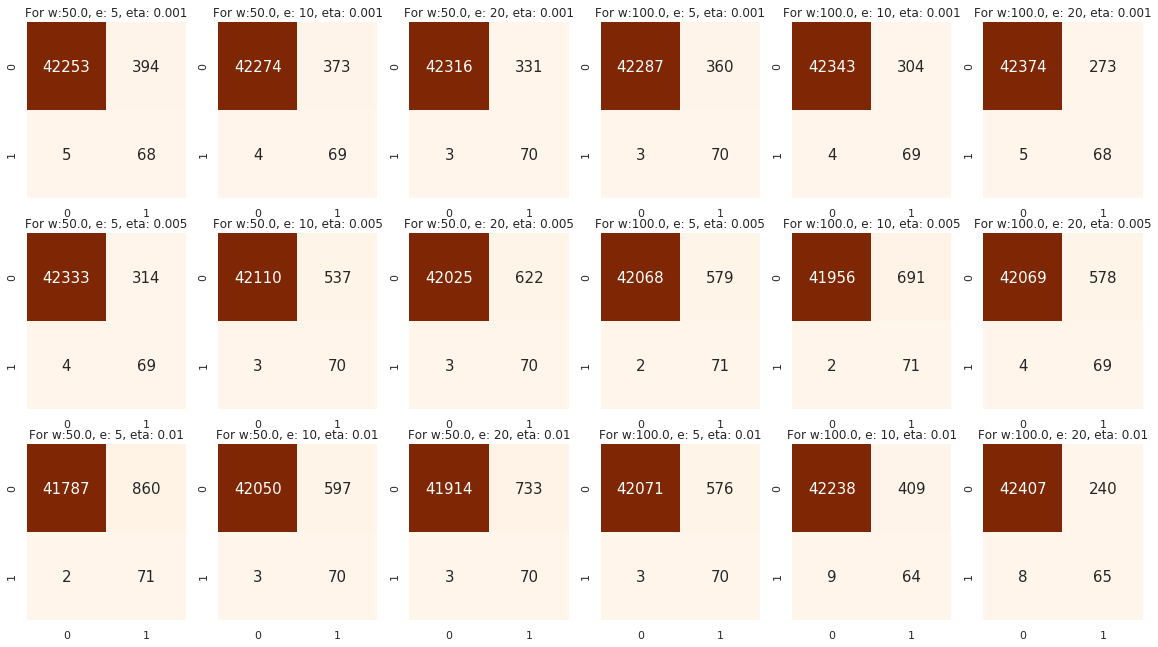

In [25]:
import pickle
fig, ax = plt.subplots(3, 6, figsize=(20, 11))

for i, learning in enumerate([0.001, 0.005, 0.01]):
    for j, weight in enumerate([50., 100.]):
        for k, epoch in enumerate([5, 10, 20]):
            file = open(f"model_eta-{learning}_w-{weight}_e-{epoch}.pickle", "rb") 
            train_model = pickle.load(file)
            file.close()
            train_predictions = train_model.predict(test, batch_size=200, verbose=0)
            train_pred =  pd.DataFrame(train_predictions[:,0] < train_predictions[:,1])
            train_pred.columns = ['Class']
            train_pred.Class.apply(lambda x : 1 if x else 0)

            sns.heatmap(confusion_matrix(test_y, train_pred), 
                        annot=True, cmap="Oranges", 
                        cbar = False, fmt='.0f', annot_kws={"fontsize":15}, ax=ax[i][j*3+k])
            bottom, top = ax[i][j*3+k].get_ylim()
            ax[i][j*3+k].set_ylim(bottom + 0.5, top - 0.5)
            ax[i][j*3+k].title.set_text(f'For w:{weight}, e: {epoch}, eta: {learning}')

## Autoencoder

In [26]:
from keras.models import Model
from keras.layers import Input
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

input_dim = train_X.shape[1]
encoding_dim = int(input_dim/2)
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [27]:
non_fraud_train_X = train_X.loc[train_y==0]
non_fraud_val_X = val_X.loc[val_y==0]

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.autoencoder",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(non_fraud_train_X, non_fraud_train_X,
                    epochs=50,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(non_fraud_val_X, non_fraud_val_X),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

plt.figure(figsize=(15, 4))
plt.plot(history['loss'])
plt.plot(history['val_loss'])

In [28]:
from keras.models import load_model
autoencoder = load_model('model.autoencoder')

In [30]:
test_pred = autoencoder.predict(test)
mse = np.mean(np.power(test_pred - test, 2), axis=1)
error = pd.DataFrame({'reconstruction_error': mse,
                        'Class': test_y})

In [31]:
error.groupby('Class').mean()

,reconstruction_error
Class,
0,0.63
1,27.54


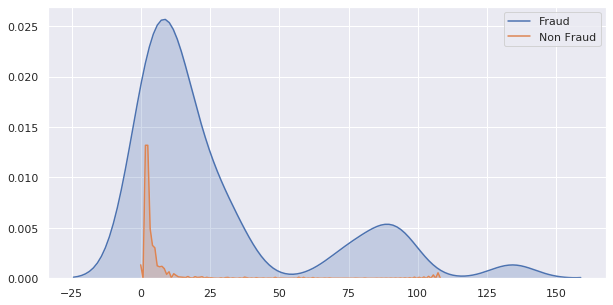

In [32]:
plt.figure(figsize=(10, 5))
sns.kdeplot(error[error.Class==1]['reconstruction_error'], shade=True)
sns.kdeplot(error[error.Class==0]['reconstruction_error'], shade=True)
plt.legend(['Fraud', 'Non Fraud'])

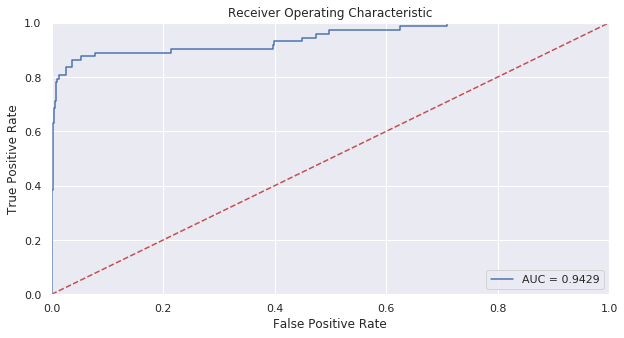

In [33]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score

fpr, tpr, thresholds = roc_curve(error.Class, error.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

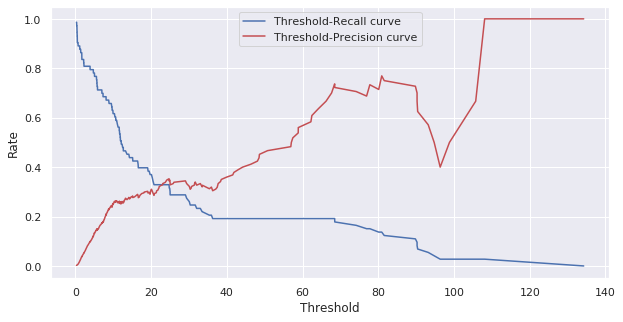

In [34]:
plt.figure(figsize=(10, 5))
precision, recall, th = precision_recall_curve(error.Class, error.reconstruction_error)
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.plot(th, precision[1:], 'r', label='Threshold-Precision curve')
plt.ylabel('Rate')
plt.xlabel('Threshold')
plt.legend()

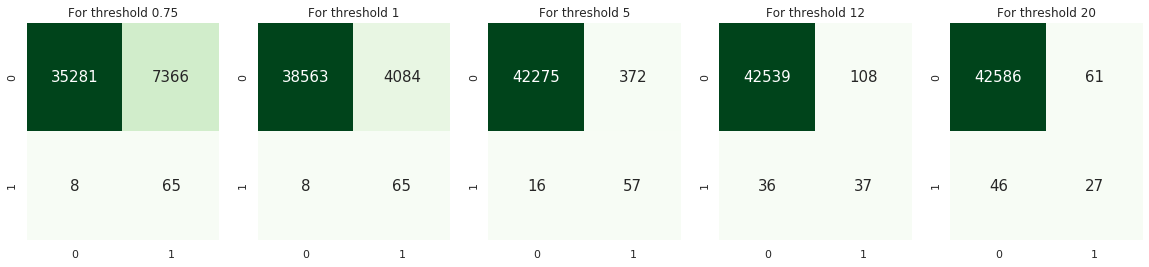

In [35]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, threshold in enumerate([0.75, 1, 5, 12, 20]):
    y_pred = error.reconstruction_error.map(lambda x: 1 if x > threshold else 0).values
    sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[i], cmap="Greens", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
    bottom, top = ax[i].get_ylim()
    ax[i].set_ylim(bottom + 0.5, top - 0.5)
    ax[i].title.set_text(f'For threshold {threshold}')

# Winner: Neural Network with entire dataset